# HR Promotion Prediction
This is a WNS Analytics Wizard competition, in which I want to evaluate my Skills.<br>
My Goal is to develop a classification model to predict whether an employee is promoted or not, and also understand the factors that lead to this promotion.


The Best F1-Score on the Leaderboard was **0.5358004827**
* Public Leaderboard score (F1) for the rank 1: 0.5358004827
* My score (F1) is 0.522 in the TOP 100

I will try to do better.

### About Data
The data-set consists of 54808 rows where each row had 14 attributes including target variable (i.e “is_promoted”).

### Table of contents:
1. Import Necessary Packages
2. Use my Predefined functions
3. Import Data
4. Exploratory Data Analysis
5. Data Cleaning
6. Preprocessing
7. Modelling<br>
   7.1 Use a Baseline Model<br>
   7.2 Parameter Tuning<br>
   7.3 Setting Optimal threshold<br>
7. Create Baseline ML Model for Binary Classification Problem.
8. Evaluation

### 1. Import necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
 
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

# Boosting Algorithms :
import xgboost as xgb
import lightgbm as lgb
 
import warnings
warnings.filterwarnings("ignore")
 
# Set all options
%matplotlib inline
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (20, 10)


### 2. Use my Predefined functions

In [2]:
def convert_categorical(d_convert):
    dt = d_convert.copy()
    list_to_drop = []
    for col in dt.columns:
        if dt[col].dtype == 'object':
            list_to_drop.append(col)
            dt = pd.concat([dt,pd.get_dummies(dt[col],prefix=col,prefix_sep='_', drop_first=False)], axis=1) 
    dt = dt.drop(list_to_drop,axis=1)
    return dt

In [3]:
def quality_check(df):
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total', 'Percent','Nunique', 'Dtype'])
    display(quality_df)

In [4]:
def score_on_test_set(model, file_name, out_name):
    test_data = pd.read_csv(file_name)
 
    # Treating the missing values of education as a separate category
    test_data['education'] = test_data['education'].replace(np.NaN, 'NA')
 
    # Treating the missing values of education as a separate category
    test_data['previous_year_rating'] = test_data['previous_year_rating'].fillna(0)
 
    # Creating dummy variables for all the categorical columns, droping that column
    master_test_data = convert_categorical_to_dummies(test_data)
 
    # Removing the id attributes
    df_test_data = master_test_data.drop(['employee_id'],axis=1)
    if out_name == "submission_lightgbm.csv":
        y_pred = model.predict_proba(df_test_data.values, num_iteration=model.best_iteration_)
    else:
        y_pred = model.predict_proba(df_test_data.values)
    submission_df = pd.DataFrame({'employee_id':master_test_data['employee_id'],'is_promoted':y_pred[:,1]})
    submission_df.to_csv(out_name, index=False)
 
    score = model.predict_proba(df_test_data.values)
    return test_data,score

### 3. Import DataSet

In [5]:
df = pd.read_csv('/project_data/data_asset/train.csv')
print("Shape of Data = ",df.shape)
df.head()

Shape of Data =  (54808, 14)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0


### 4. Exploratory Data Analysis

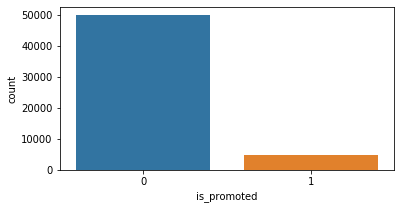

0    50140
1     4668
Name: is_promoted, dtype: int64

In [6]:
plt.figure(figsize=(6,3))
sns.countplot(x='is_promoted',data=df)
plt.show()
 
# Checking How many time employees get promoted in our dataset
df['is_promoted'].value_counts()

In [7]:
# Checking the attribute names
pd.DataFrame(df.columns,columns = ["Attributes"])

,Attributes
0,employee_id
1,department
2,region
3,education
4,gender
5,recruitment_channel
6,no_of_trainings
7,age
8,previous_year_rating
9,length_of_service


### Let's Look at the attributes

* Best promotions are in technology department (10.7%).
* worst promotions are  in Legal department. 
* Region 9 is the best in terms of promotions (14.4%).
* Region 4 is the worst in terms of promotions (1.9%).
* Employess having KPI greater than 80% has good chances of promotions (16%)
* Employees winning awards are promoted more (44%).

In [8]:
for col in df.drop('is_promoted',axis=1).columns:
    if df[col].dtype == 'object'or df[col].nunique() == 2:
        count = df.groupby(col)['is_promoted'].value_counts().unstack(1)
        per_not_promoted = count.iloc[:, 0] *100/count.apply(lambda x: x.sum(), axis=1)
        per_promoted = count.iloc[:, 1]*100/count.apply(lambda x: x.sum(), axis=1)
        count['%_0'] = per_not_promoted
        count['%_1'] = per_promoted
        display(count)

is_promoted,0,1,%_0,%_1
department,,,,
Analytics,4840,512,90.4335,9.5665
Finance,2330,206,91.8770,8.1230
HR,2282,136,94.3755,5.6245
Legal,986,53,94.8989,5.1011
Operations,10325,1023,90.9852,9.0148
Procurement,6450,688,90.3614,9.6386
R&D,930,69,93.0931,6.9069
Sales & Marketing,15627,1213,92.7969,7.2031
Technology,6370,768,89.2407,10.7593


is_promoted,0,1,%_0,%_1
region,,,,
region_1,552,58,90.4918,9.5082
region_10,597,51,92.1296,7.8704
region_11,1241,74,94.3726,5.6274
region_12,467,33,93.4000,6.6000
region_13,2418,230,91.3142,8.6858
region_14,765,62,92.5030,7.4970
region_15,2586,222,92.0940,7.9060
region_16,1363,102,93.0375,6.9625
region_17,687,109,86.3065,13.6935


is_promoted,0,1,%_0,%_1
education,,,,
Bachelor's,33661,3008,91.7969,8.2031
Below Secondary,738,67,91.6770,8.3230
Master's & above,13454,1471,90.1441,9.8559


is_promoted,0,1,%_0,%_1
gender,,,,
f,14845,1467,91.0066,8.9934
m,35295,3201,91.6849,8.3151


is_promoted,0,1,%_0,%_1
recruitment_channel,,,,
other,27890,2556,91.6048,8.3952
referred,1004,138,87.9159,12.0841
sourcing,21246,1974,91.4987,8.5013


is_promoted,0,1,%_0,%_1
KPIs_met >80%,,,,
0,34111,1406,96.0413,3.9587
1,16029,3262,83.0906,16.9094


is_promoted,0,1,%_0,%_1
awards_won?,,,,
0,49429,4109,92.3251,7.6749
1,711,559,55.9843,44.0157


In [9]:
df['department'].nunique()

9

In [10]:
quality_check(df)

,Total,Percent,Nunique,Dtype
KPIs_met >80%,0,0.0000,2,int64
age,0,0.0000,41,int64
avg_training_score,0,0.0000,61,int64
awards_won?,0,0.0000,2,int64
department,0,0.0000,9,object
education,2409,4.3953,3,object
employee_id,0,0.0000,54808,int64
gender,0,0.0000,2,object
is_promoted,0,0.0000,2,int64
length_of_service,0,0.0000,35,int64


We observe that we have missing values on the following columns : **education** and **previous_year_rating**

### 5. Data Cleaning

In [11]:
# Treating the missing values of education as a separate category
df['education'] = df['education'].replace(np.NaN, 'NA')
 
# Treating the missing values of previous year rating as 0
df['previous_year_rating'] = df['previous_year_rating'].fillna(0)

In [12]:
df.select_dtypes(include='object').head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


### 6. Preprocessing

In [13]:
# Encode categorical variables
Training_data = convert_categorical(df)

In [14]:
# dropping the target from dataset
labels = np.array(Training_data['is_promoted'].tolist())


In [15]:
# Removing the id attributes
df_data = Training_data.drop(['is_promoted','employee_id'],axis=1)
df = df_data.values

### 7. Modeling


#### Baseline Model
Since we have unbalanced dataset, The accuracy will not be recommended, we will use the F1-Score instead

In [16]:
xgb_model = xgb.XGBClassifier()
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1')
print(f1_scores," Mean = ",np.mean(f1_scores))

f1_scores_acc = cross_val_score(xgb_model, df, labels, cv=5, scoring='accuracy')
print(f1_scores_acc," Mean = ",np.mean(f1_scores_acc))

# Training the models
xgb_model.fit(df,labels)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[0.4526749  0.41547519 0.43579122 0.43012552 0.43427621]  Mean =  0.43366860671698976
[0.93933589 0.93659916 0.9378763  0.93787063 0.93796186]  Mean =  0.9379287690658098


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Parameter Tuning

Our goal is usually to set the model parameters to optimal values that enable a model to complete learning task in the best way possible.

In [17]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [1000],
     'max_depth':[8],
     'reg_alpha':[0.4]
    }

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()

# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)

gsearch.fit(df, labels)

#Printing the best chosen params
print(gsearch.best_params_)

params = {'objective':'binary:logistic', 'booster':'gbtree'}

# Updating the parameter as per grid search
params.update(gsearch.best_params_)

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1',n_jobs=2)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Fitting model on tuned parameters
xgb_model.fit(df, labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.9min finished


{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[0.51014041 0.48657188 0.49606299 0.53054911 0.50855365]  Mean =  0.5063756086035844


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Setting Optimal threshold

Our model predicts 0 and 1 by putting a threshold at 0.5 by default (1 if probability > 0.5). In unbalance data-set as in here, it may be a biased setting as it would be difficult to capture rare event with 0.5 threshold.

We can change the by default threshold of 0.5 by finding the optimal threshold to increase F1-score

Let's split 80:20 and trains XGBoost classifier with tuned parameters. It calculates precision and recall at different thresholds and plots the precision recall curve. Further, we calculate F1-score for the same using precision and recall values.

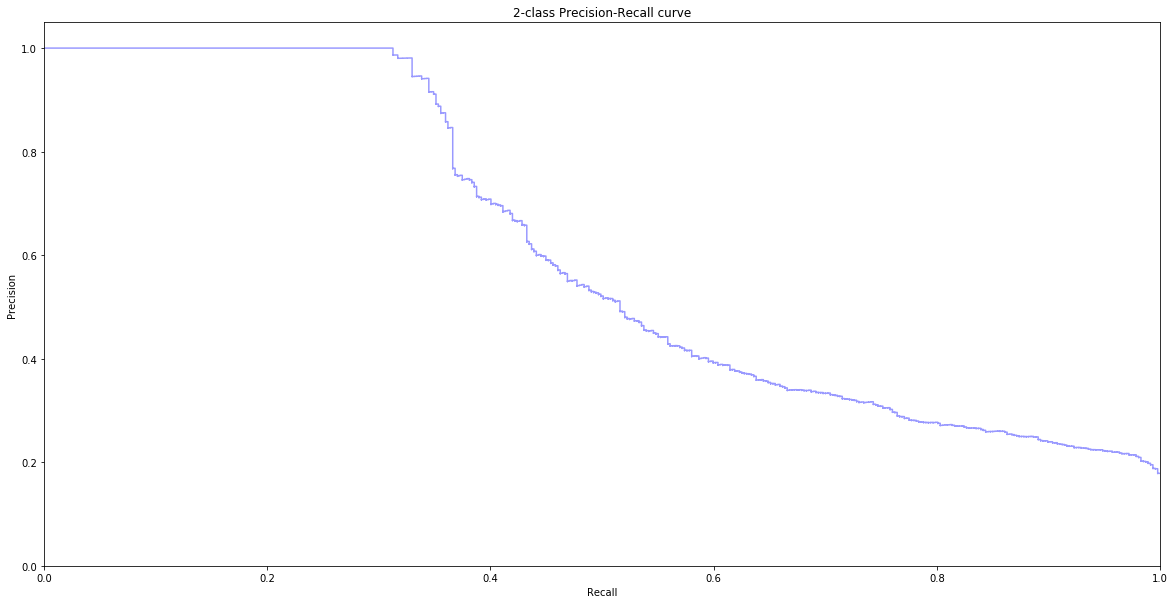

In [18]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.10, stratify=labels)
 
xgb_model = xgb.XGBClassifier(**params)
 
# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
 
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

### Getting optimal threshold
The below python codes gets the threshold value where the F1-score was highest.

Threshold cutoff:  0.267270028591156
Max F1-score at cut-off :  0.5219638242894057


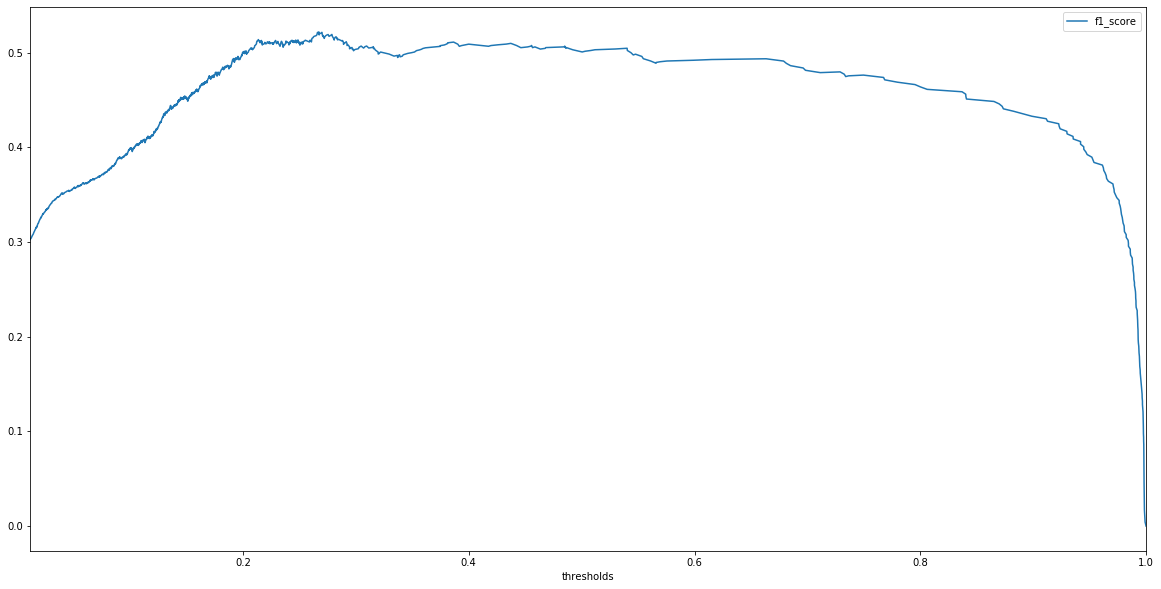

In [19]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

### Conclusion
* This score (0.522) Put in the TOP 100 in the Leaderboard.
* The best score in the Leaderboard is 0.535 
* I think with some Feature Creation (Creation of New Feature from the Existing Features) I can have a better score.
* I tried different models (SVM, Logistic Regression, Random Forrest) but the F1-score was comparatively low.
* I also tried Ensemble modeling but it did not gave better f1 than individual XGB Classifier model.